In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def draw_hsv():
    # Define the size of the image
    width = 180  # Hue varies from 0 to 360
    height = 255  # Saturation varies from 0 to 100

    # Create an empty array to store the HSV values
    hsv_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Set the hue and saturation values
    for x in range(width):
        for y in range(height):
            hsv_image[y, x, 0] = x  # Hue
            hsv_image[y, x, 1] = y  # Saturation
            hsv_image[y, x, 2] = 255  # Value

    # Convert the HSV image to RGB for display
    rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    # Create a new figure with a specific size (width, height)
    plt.figure(figsize=(15, 3))  # You can adjust these values as needed

    # Display the image
    plt.imshow(rgb_image, aspect='auto')
    plt.xlabel('Hue')
    plt.ylabel('Saturation')
    plt.show()

In [2]:
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os


# Input and Output Folders
input_folder = os.path.join('representative_sample_input')
output_folder_figures = os.path.join( 'output_figures')
output_folder_images = os.path.join( 'output_images')
mask_folder = os.path.join('masks')

# Function to check if a pixel is in the selected colors.
def is_color(rgb, lower_hue, upper_hue, lower_value, upper_value, lower_saturation):
    # convert rgb to hsv
    hsv = cv.cvtColor(np.array([[rgb]], dtype=np.uint8), cv.COLOR_RGB2HSV)[0][0]
    
    # get the hue, saturation and value 
    hue = hsv[0]
    saturation = hsv[1]
    value = hsv[2]
    # check if hue is in the range of hues and value is not too dark or too light (brightness)
    return ((lower_value <= value <= upper_value) & (lower_hue <= hue <= upper_hue) & (saturation > lower_saturation))

# Function to decrease the brightness of the image
def decrease_brightness(img, mask):
    # Convert the image to HSV color space
    hsv_img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    # Define the brightness adjustment factor (you can change this value to control the brightness)
    darkening_factor = 0.25
    # Set the brightness channel (V) of the pixels with mask value 1 to a lower value
    hsv_img[:, :, 2] = np.where(mask == 0, hsv_img[:, :, 2] * darkening_factor, hsv_img[:, :, 2])
    # Convert the image back to RGB color space
    modified_img = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)
    
    return modified_img

def plot(original, mask, mask2, img, file_name):
    #PLOTTING THE IMAGES
    fig = plt.figure(figsize=(10, 10))  
    # setting values to rows and column variables
    rows = 2
    columns = 2

    # Adds a subplot
    fig.add_subplot(rows, columns, 1)
    # showing image
    plt.imshow(original)
    plt.axis('off')
    plt.title("original")

    # Adds a subplot
    fig.add_subplot(rows, columns, 2)
    # showing image
    plt.imshow(mask)
    plt.colorbar()
    plt.axis('off')
    plt.title("mask")

    # Adds a subplot
    fig.add_subplot(rows, columns, 3)
    # showing image
    plt.imshow(mask2)
    plt.colorbar()
    plt.axis('off')
    plt.title("GrabCut result")

    # Adds a subplot
    fig.add_subplot(rows, columns, 4)
    # showing image
    plt.imshow(img)
    plt.axis('off')
    plt.title("result")

    # Save the figures to the output folder
    output_path = os.path.join(output_folder_figures, "figures_" + file_name)
    plt.savefig(output_path)
    plt.close()


def process(file_name, lower_hue, upper_hue, lower_value, upper_value, lower_saturation, param_selection = False):
    if not param_selection:
        print("Processing", file_name)
    # Read the input image
    input_path = os.path.join(input_folder, file_name)
    img = cv.imread(input_path)
    if param_selection:
        img = cv.resize(img, (round(img.shape[1]/20), round(img.shape[0]/20))) #downsizing image for faster runtime
    else:
        img = cv.resize(img, (round(img.shape[1]/4), round(img.shape[0]/4))) #downsizing image for faster runtime
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    original = img

    assert img is not None, "file could not be read, check with os.path.exists()"

    #mask cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            current_R = img[i,j][0] #temporary variables for pixel
            current_G = img[i,j][1]
            current_B = img[i,j][2]

            if(is_color((current_R,current_G,current_B), lower_hue, upper_hue, lower_value, upper_value, lower_saturation)):
                mask[i,j] = 1
            else:
                mask[i,j] = 2
    if not param_selection:
        np.save(mask_folder + "/grabCut_input_mask_" + file_name[:-4] + ".npy", mask)



    # mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,0,img.shape[0],img.shape[1])
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,iterCount=5, mode=cv.GC_INIT_WITH_MASK)
    #making a mask which is 1 where the mask is 1 or 3 (foreground) and 0 where the mask is 0 or 2 (background)
    mask2 = np.where((mask==2)|(mask==0),0,1)
    img = decrease_brightness(img, mask2)
    if not param_selection:
        plot(original, mask, mask2, img, file_name)
        np.save(mask_folder + "/grabCut_output_mask_" + file_name[:-4] + ".npy", mask2)
        cv.imwrite(output_folder_images+ "/" + file_name, img)
    return img

SelectMultiple(description='Files:', options=('115_w1.jpg',), value=())

Button(description='Apply Parameters', style=ButtonStyle())

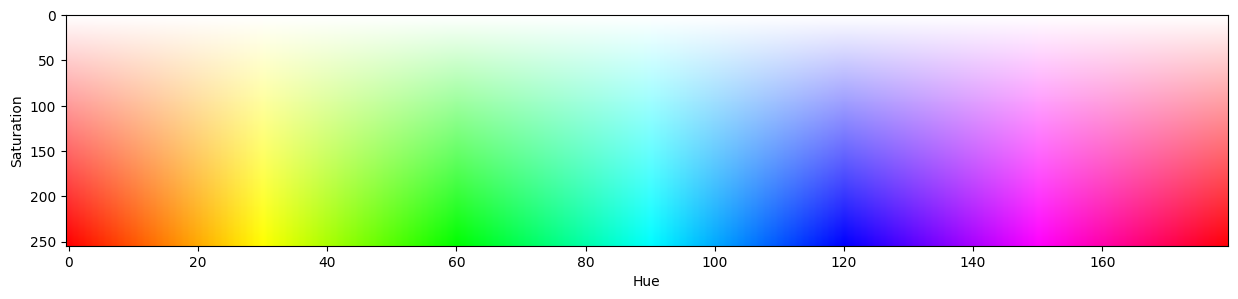

In [5]:
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display
import os
import mplcursors

# define the range of yellow hues
lower_hue = 20
upper_hue = 60

# define the range of acceptable brightness values
lower_value = 225
upper_value = 250 #really good results with 251 and 252

#define minimum saturation
lower_saturation = 150

# List all image files in the input folder except 'README.md'
image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f != 'README.md']
# Create three output widgets to display the images
output_image1 = widgets.Output()
output_image2 = widgets.Output()
output_image3 = widgets.Output()

# Create a dropdown widget to select the file
file_dropdown = widgets.Dropdown(
    options=image_files,
    description='File:'
)

# Create a SelectMultiple widget to select the files
file_select = widgets.SelectMultiple(
    options=image_files,
    description='Files:'
)

# Create sliders for color and saturation parameters
color_slider = widgets.IntRangeSlider(
    value=[lower_hue, upper_hue],
    min=0,
    max=180,
    step=1,
    description='Color Range:',
    continuous_update=False
)

brightness_slider = widgets.IntRangeSlider(
    value=[lower_saturation, 255],
    min=0,
    max=255,
    step=1,
    description='Brightness:',
    continuous_update=False
)

lower_saturation_slider = widgets.IntSlider(
    value=lower_saturation,
    min=0,
    max=255,
    step=1,
    description='Saturation:',
    continuous_update=False
)


# Create a button
update_button = widgets.Button(description='Apply Parameters')

# # Create an output widget to display the image
# output_image = widgets.Output()

# Define a function to update the images based on the selected values
def update_images(button):
    # Clear the previous outputs
    output_image1.clear_output()
    output_image2.clear_output()
    output_image3.clear_output()
    
    # Update the color and saturation parameters
    lower_hue, upper_hue = color_slider.value
    lower_value, upper_value = brightness_slider.value
    lower_saturation = lower_saturation_slider.value
    
    # Get the selected files
    selected_files = file_select.value
    
    # Apply the color selection to each image and display it
    for i, file_name in enumerate(selected_files):
        processed_image = process(file_name, lower_hue, upper_hue, lower_value, upper_value, lower_saturation, param_selection=True)
        
        with [output_image1, output_image2, output_image3][i]:
            plt.imshow(processed_image)
            plt.axis('off')
            plt.show()


# Register the update_image function to be called when the button is clicked
update_button.on_click(update_images)

# Register the update function to be called when the dropdown value changes
file_dropdown.observe(update_images, 'value')


# Display the SelectMultiple and the output images in a horizontal box
display(file_select, widgets.HBox([output_image1, output_image2, output_image3]), widgets.HBox([color_slider, brightness_slider, lower_saturation_slider]), update_button)
draw_hsv()


In [7]:

# Create output and mask folder if it doesn't exist
if not os.path.exists(output_folder_figures):
    os.makedirs(output_folder_figures)
if not os.path.exists(mask_folder):
    os.makedirs(mask_folder)
if not os.path.exists(output_folder_images):
    os.makedirs(output_folder_images)

# List all image files in the input folder except 'README.md'
image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f)) and f != 'README.md']

# Process each image file
for file_name in image_files:
    process(file_name, lower_hue, upper_hue, lower_value, upper_value, lower_saturation)


Processing 115_w1.jpg
